# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
from time import process_time
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
df= pd.read_csv('/datasets/autos.csv')
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Описание признаков

**Признаки**

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

NotRepaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя


**Целевой признак**

Price — цена (евро)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Посмотрю сколько дубликатов

In [4]:
df.duplicated().sum()

4

In [5]:
# Уберу дубликаты
df = df.drop_duplicates().reset_index(drop=True)

In [6]:
# Проверю удалось убрать дубликаты
df.duplicated().sum()

0

### Посмотрим на кол-во пропусков и заполним их

In [7]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
NotRepaired,71154,0.200793
VehicleType,37490,0.105795
FuelType,32895,0.092828
Gearbox,19833,0.055968
Model,19705,0.055607
DateCrawled,0,0.000000
Price,0,0.000000
RegistrationYear,0,0.000000
Power,0,0.000000
Kilometer,0,0.000000


Как видно очень много пропусков в следующих признаках

VehicleType — тип автомобильного кузова

Gearbox — тип коробки передач

Model — модель автомобиля

FuelType — тип топлива

NotRepaired — была машина в ремонте или нет

In [8]:
# проверю тип данных
df[['NotRepaired','VehicleType','FuelType','Gearbox','Model']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   NotRepaired  283211 non-null  object
 1   VehicleType  316875 non-null  object
 2   FuelType     321470 non-null  object
 3   Gearbox      334532 non-null  object
 4   Model        334660 non-null  object
dtypes: object(5)
memory usage: 13.5+ MB


Заменим все пропуски на значение unknown(неизвестно)

In [9]:
df[['NotRepaired','VehicleType','FuelType','Gearbox','Model']]=df[['NotRepaired','VehicleType','FuelType','Gearbox','Model']].fillna('unknown')

In [10]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,2016-03-21 09:50:58,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354361,2016-03-14 17:48:27,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354362,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354363,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


### Расмотрю влияние признаков на цену

Посмотрю зависимость выкладывания обьявления от месяца

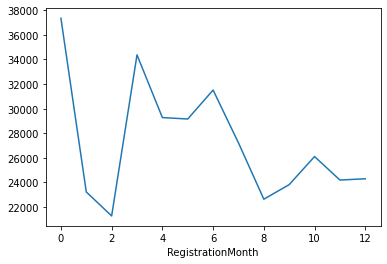

In [11]:
df_RegistrationMonth=df.groupby('RegistrationMonth').size().plot()


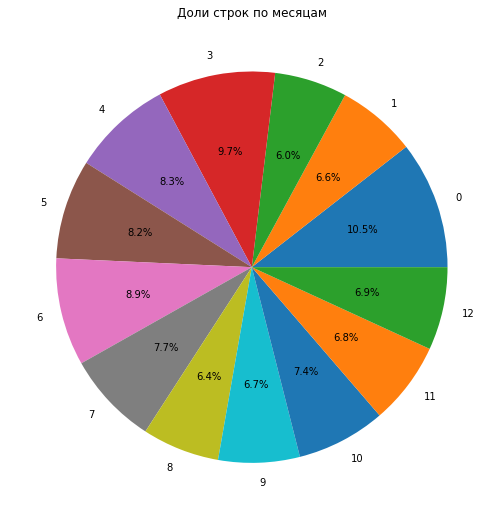

In [12]:
import matplotlib.pyplot as plt
df_RegistrationMonth=df.groupby('RegistrationMonth').size().plot(kind='pie', figsize=(9,9),autopct='%1.1f%%')
plt.title("Доли строк по месяцам")
plt.ylabel("")
plt.show()

Рассмотрим корреляцию признаков от цены

In [13]:
data=df[['Price','RegistrationYear','Power','Kilometer','RegistrationMonth']]

In [14]:
#sns.pairplot(data)

In [15]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.026916,0.158872,-0.333207,0.110580
RegistrationYear,0.026916,1.000000,-0.000828,-0.053448,-0.011619
Power,0.158872,-0.000828,1.000000,0.024006,0.043379
Kilometer,-0.333207,-0.053448,0.024006,1.000000,0.009575
RegistrationMonth,0.110580,-0.011619,0.043379,0.009575,1.000000


In [16]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650
std,4514.176349,90.228466,189.851330,37905.083858,3.726432
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


Лучшая зависимость от цены у признака Power и обратная зависимость у киллометрожа

In [17]:
df.pivot_table(index='VehicleType',values='Price',aggfunc='mean')

,Price
VehicleType,
bus,5487.071347
convertible,6807.014305
coupe,6011.226409
other,3563.838200
sedan,4722.660496
small,2677.672454
suv,9009.206485
unknown,2375.427954
wagon,4880.390424


#### Функция для анализа признаков

#### Функция для виуализации распределение признаков

In [18]:
# Функция для виуализации распределение признаков
def print_hist(row,colum):
    print('Признак',colum)
    print(row[colum].describe())
    row[colum].hist(figsize=(15,9))
    plt.show()
    plt.figure(figsize=(15,9))
    sns.boxplot(x = row[colum])

####  Функция зависимости корреляции с целевым признаком

In [19]:
# Функция зависимости корреляции с целевым признаком
def corr_columns(row,columns_target,columns):
    print("Оцениваю зависимость признака",columns, "От Целевого признака",columns_target)
    row.pivot_table(index=columns,values=columns_target,aggfunc='mean').plot()
    plt.show()
    



#### Запуск функций

In [20]:
# Определяю численые признаки
num_columns = df.dtypes[df.dtypes!="object"].index.values

Признак Price
count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64


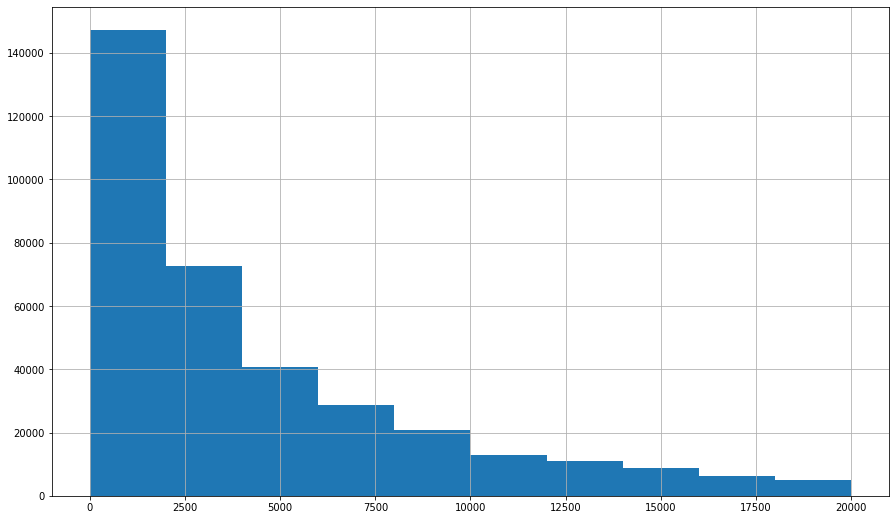

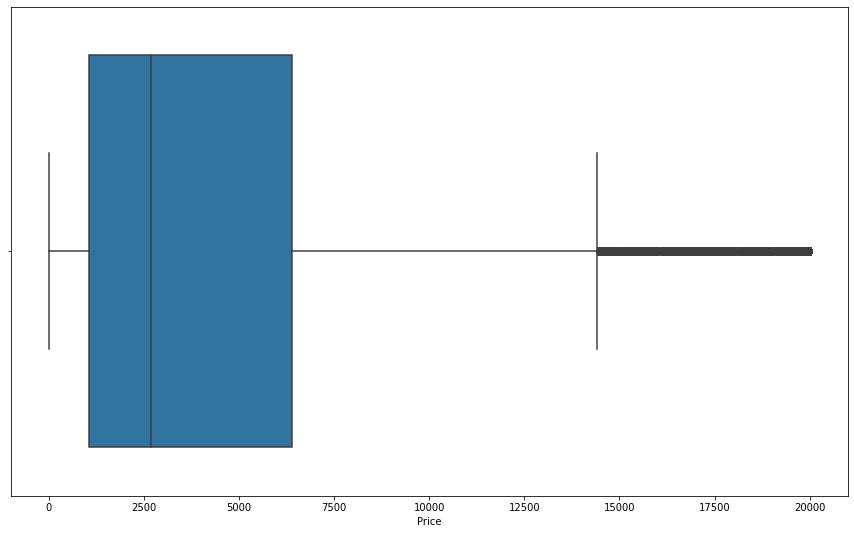

Признак RegistrationYear
count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


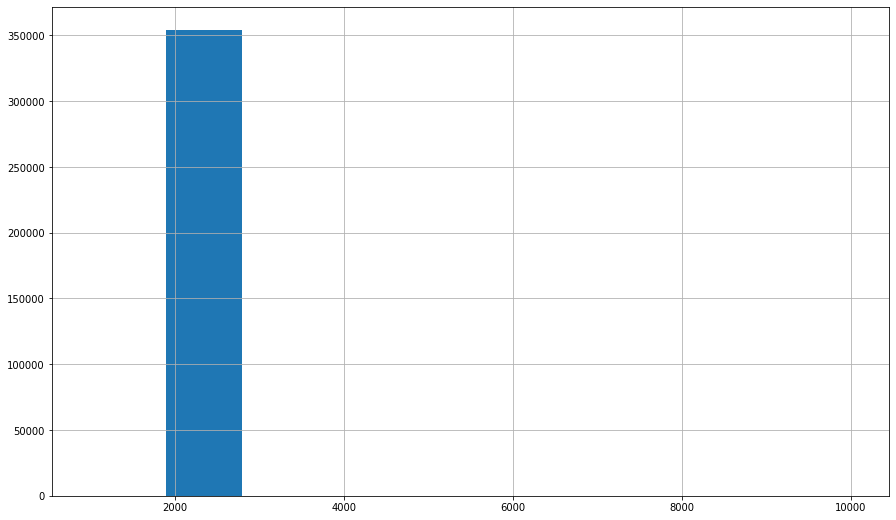

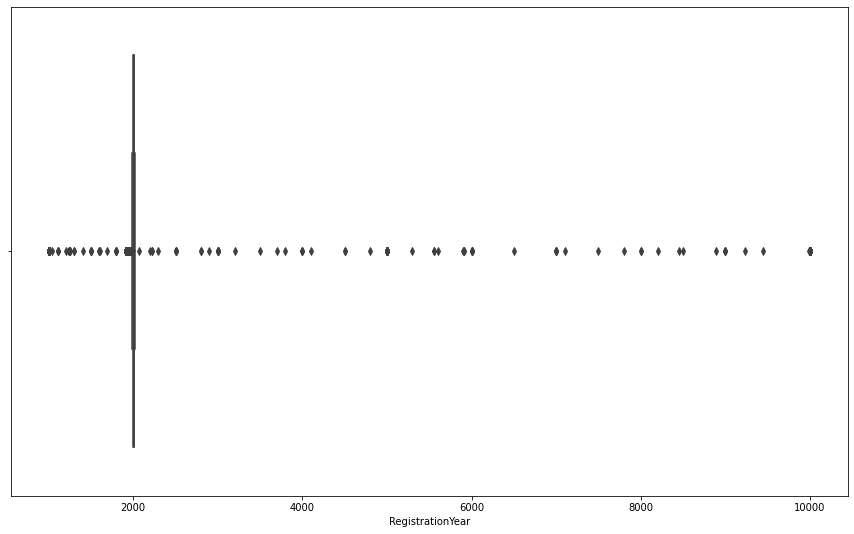

Признак Power
count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


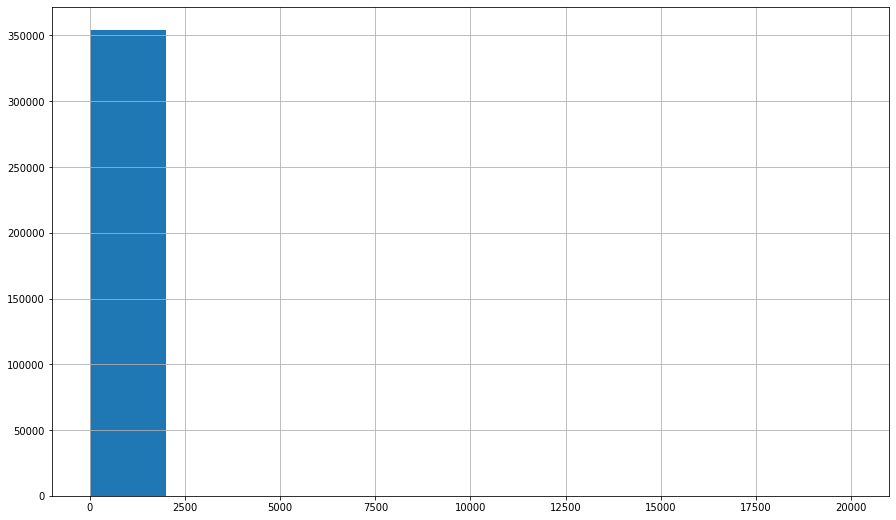

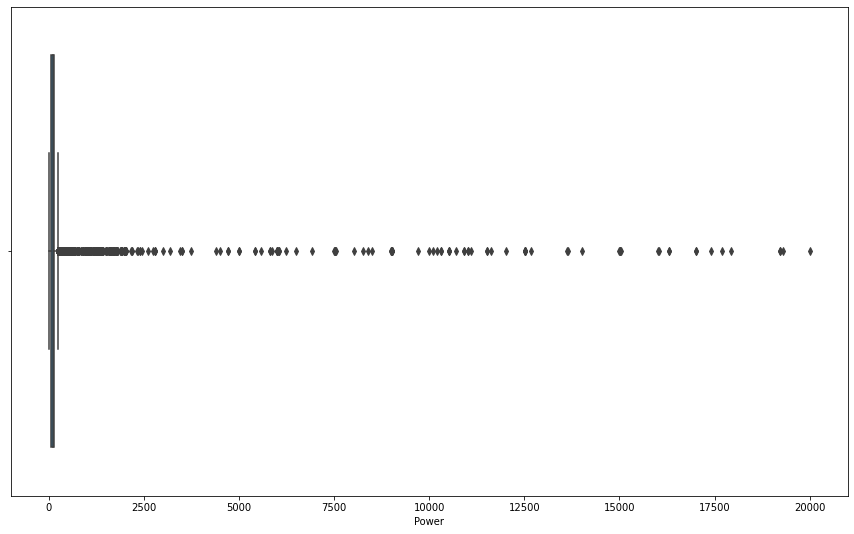

Признак Kilometer
count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


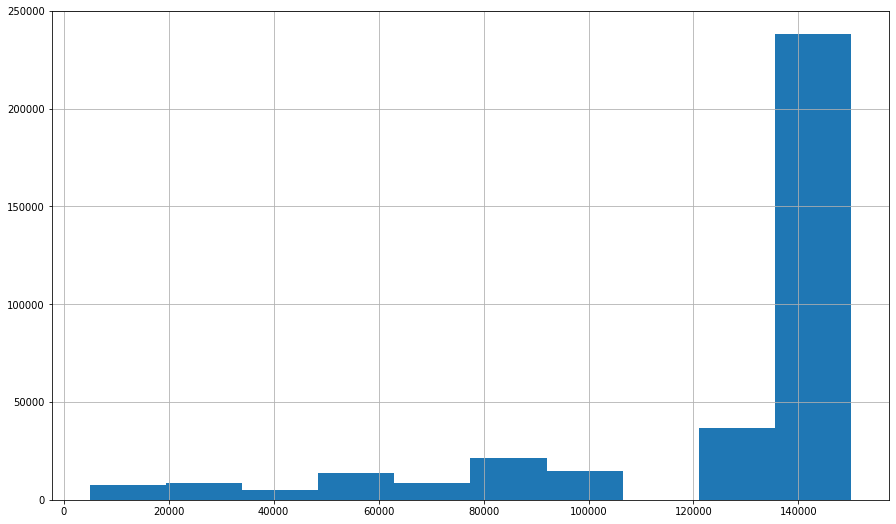

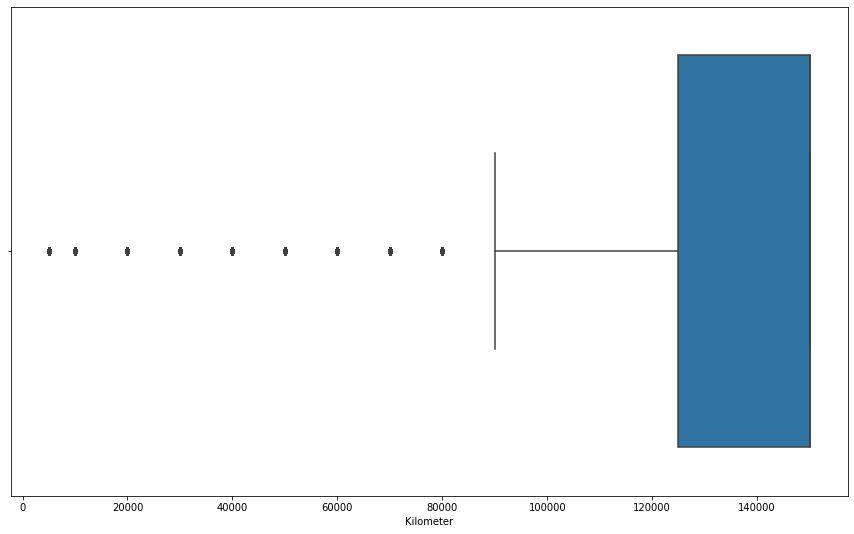

Признак RegistrationMonth
count    354365.000000
mean          5.714650
std           3.726432
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64


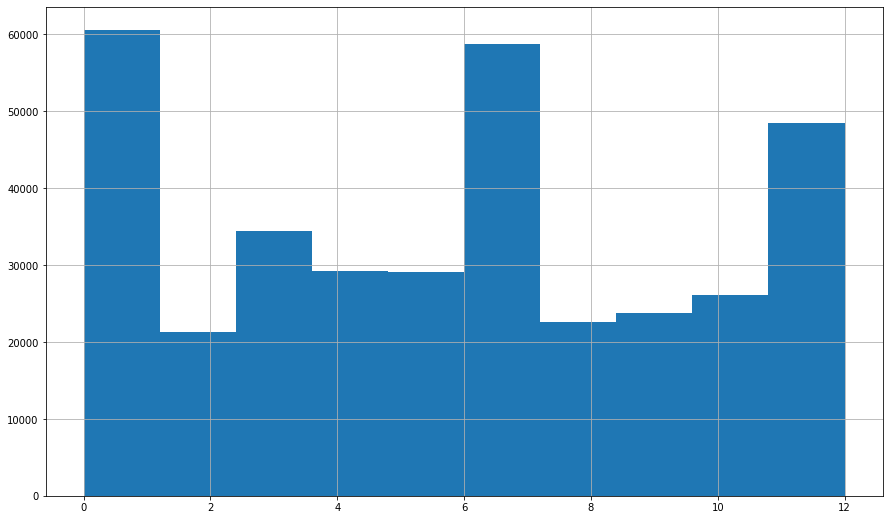

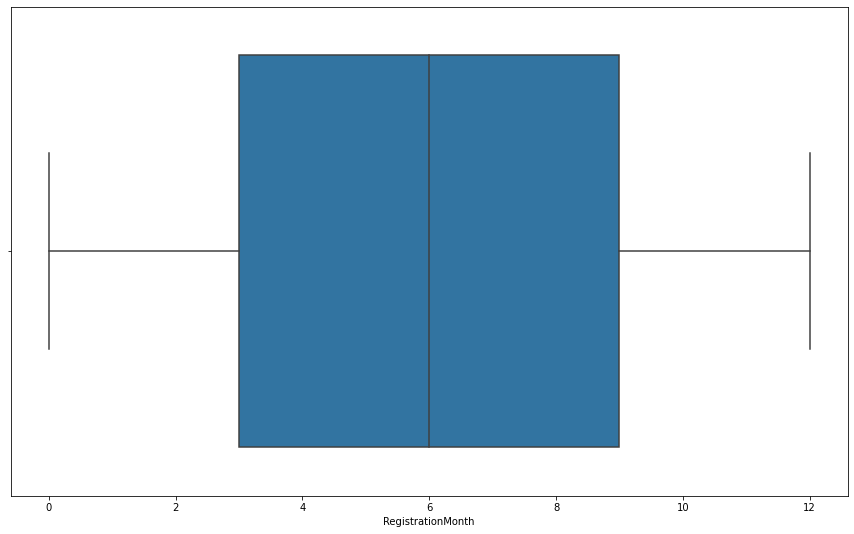

Признак NumberOfPictures
count    354365.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64


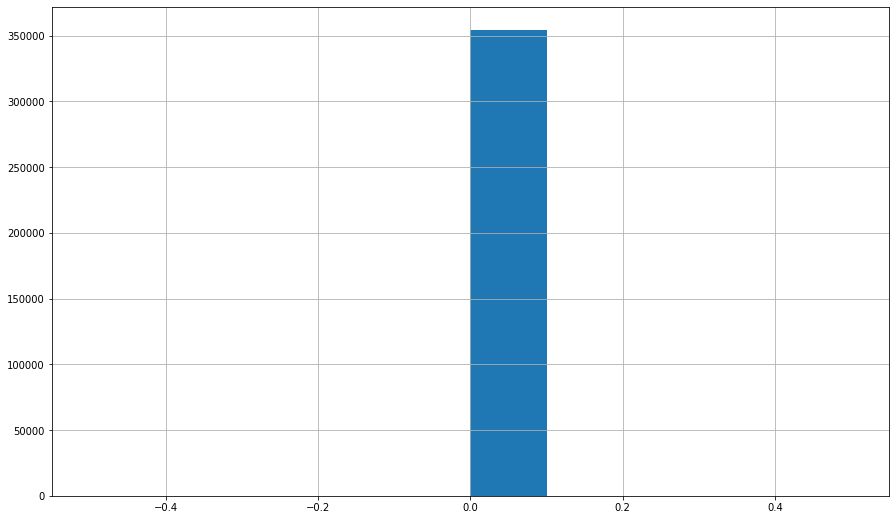

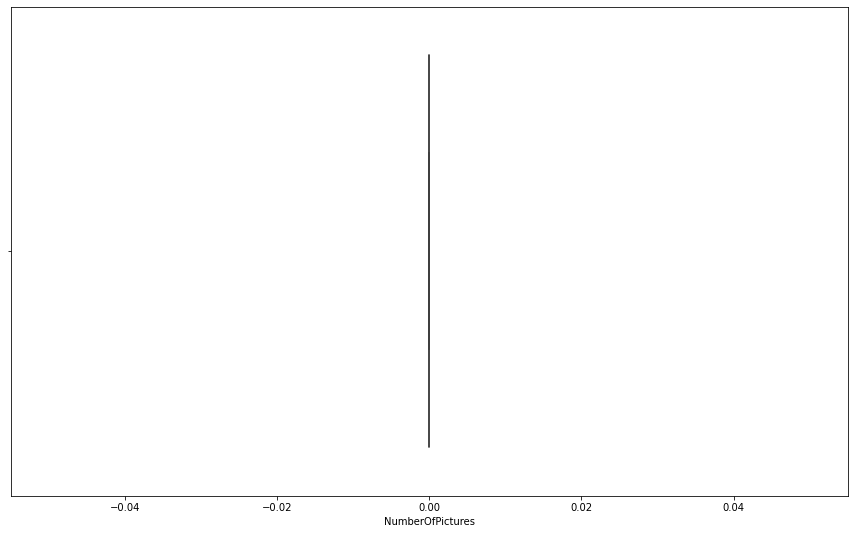

Признак PostalCode
count    354365.000000
mean      50508.503800
std       25783.100078
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: PostalCode, dtype: float64


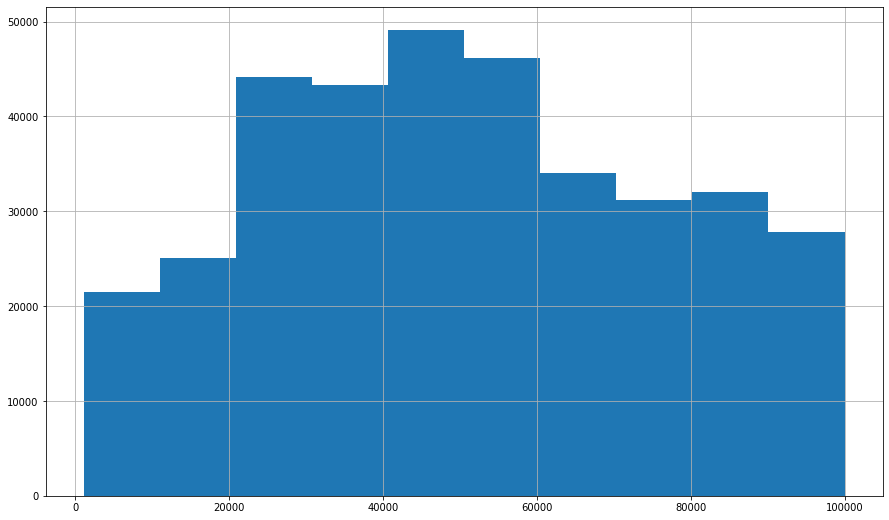

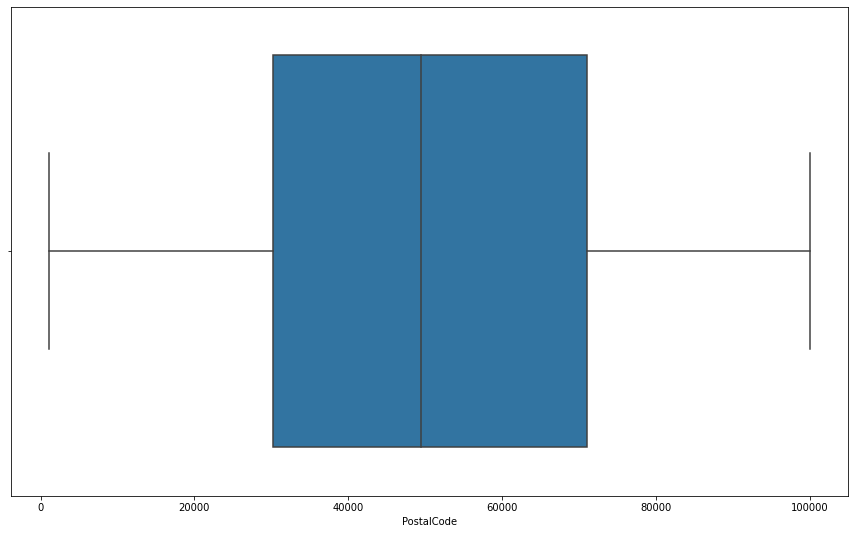

In [21]:
# функция print_hist
for i in num_columns:
    print_hist(df,i)
    plt.show()

#print_hist(df,'Price') 

In [22]:

new_num_columns=[]
for i in num_columns:
    if i=='Price':
        i=i
    else:
        new_num_columns.append(i)
new_num_columns

['RegistrationYear',
 'Power',
 'Kilometer',
 'RegistrationMonth',
 'NumberOfPictures',
 'PostalCode']

In [23]:
# Чищу список, что бы целевой признак не попадался
target='Price' #Задаю целевой признак
new_num_columns = [i for i in num_columns if i != target]
new_num_columns

['RegistrationYear',
 'Power',
 'Kilometer',
 'RegistrationMonth',
 'NumberOfPictures',
 'PostalCode']

Оцениваю зависимость признака RegistrationYear От Целевого признака Price


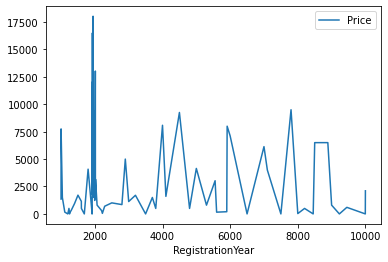

Оцениваю зависимость признака Power От Целевого признака Price


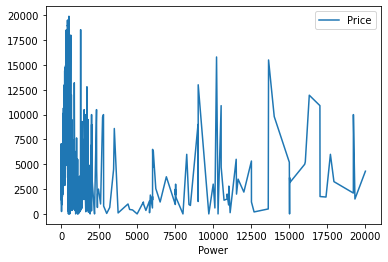

Оцениваю зависимость признака Kilometer От Целевого признака Price


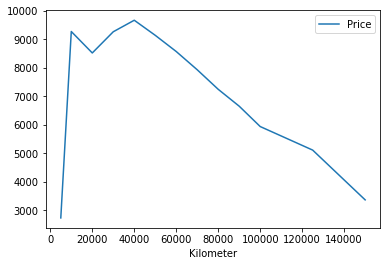

Оцениваю зависимость признака RegistrationMonth От Целевого признака Price


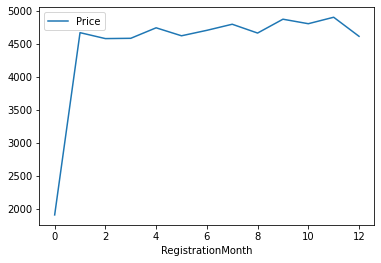

Оцениваю зависимость признака NumberOfPictures От Целевого признака Price


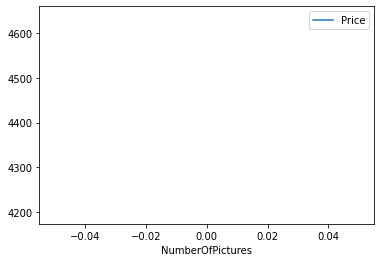

Оцениваю зависимость признака PostalCode От Целевого признака Price


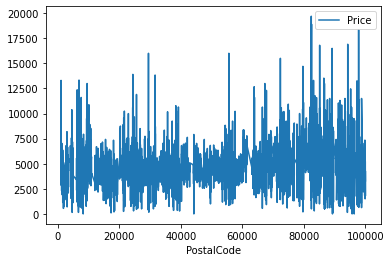

In [24]:
# функция corr_columns(df,'VehicleType')

for i in new_num_columns:
    corr_columns(df,target,i)
    plt.show()
    

### Рассмотрим аномальные значения

Price - цена

<AxesSubplot:>

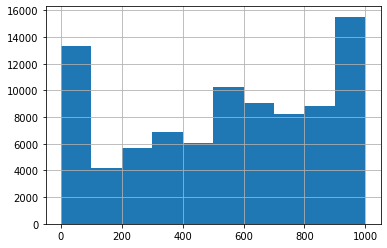

In [25]:
df['Price'].hist(range=(0, 1000))

Как видно очень много обьявлений с  маленькими ценами, автомобиль меньше 100 евро не может стоить. Так как фактическое состояние автомобили может быть очень плохим, по этому лучше удалить эти значения

In [26]:
df=df.query('Price>99')

Power -мощьность автомобиля в л.с

<AxesSubplot:>

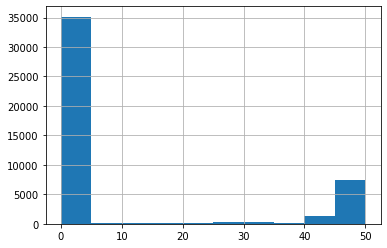

In [27]:
df['Power'].hist(range=(0, 50))

<AxesSubplot:>

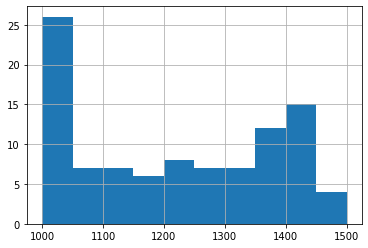

In [28]:
df['Power'].hist(range=(1000,1500))

<AxesSubplot:>

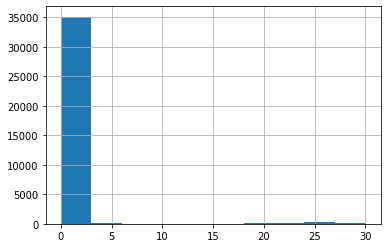

In [29]:
df['Power'].hist(range=(0,30))

### Заполнение аномальных значений

### Посмотрим на год регистрации автомобиля


In [30]:

df_RegistrationYear=df.sort_values(by='RegistrationYear')
df_RegistrationYear['RegistrationYear'].unique()

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 7000, 7100, 7800,
       8200, 8500, 8888, 9000, 9450, 9999])

In [31]:
df = df.copy()

In [32]:
df.loc[(df['RegistrationYear'] > 2020) | (df['RegistrationYear'] <= 1922), 'RegistrationYear'] = None

In [33]:
len(df[df['RegistrationYear'].isna()])

149

In [34]:
df['RegistrationYear'] = df['RegistrationYear'].fillna(df.groupby(['VehicleType','Power','Model'])['RegistrationYear'].transform('mean'))

In [35]:
len(df[df['RegistrationYear'].isna()])

15

In [36]:
df.loc[(df['RegistrationYear'] > 2020) | (df['RegistrationYear'] <= 1922), 'RegistrationYear'] = None
df['RegistrationYear'] = df['RegistrationYear'].fillna(df.groupby(['Model'])['RegistrationYear'].transform('mean'))

In [37]:
len(df[df['RegistrationYear'].isna()])

0

In [38]:
df.query('RegistrationYear>2020 or RegistrationYear<1922')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


Как видно все возможные значения по году регистрации мы заполнили остались только неизвестные модели

In [39]:
df.loc[(df['RegistrationYear'].isna())]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


Проверю на сколько корректно заменились значения

In [40]:
df_RegistrationYear=df.sort_values(by='RegistrationYear')
df_RegistrationYear['RegistrationYear'].unique()

array([1923.        , 1925.        , 1927.        , 1928.        ,
       1929.        , 1930.        , 1931.        , 1932.        ,
       1933.        , 1934.        , 1935.        , 1936.        ,
       1937.        , 1938.        , 1940.        , 1941.        ,
       1942.        , 1943.        , 1944.        , 1945.        ,
       1946.        , 1947.        , 1948.        , 1949.        ,
       1950.        , 1951.        , 1952.        , 1953.        ,
       1954.        , 1955.        , 1956.        , 1957.        ,
       1958.        , 1959.        , 1960.        , 1961.        ,
       1962.        , 1963.        , 1964.        , 1965.        ,
       1966.        , 1967.        , 1968.        , 1969.        ,
       1970.        , 1971.        , 1972.        , 1973.        ,
       1974.        , 1975.        , 1976.        , 1977.        ,
       1978.        , 1979.        , 1980.        , 1980.11627907,
       1981.        , 1982.        , 1982.6       , 1982.85714

Значения изминились на дробные, на обучение это не повлияет

In [41]:
# Удалю аномальные значения года выпуска автомобиля
df=df.dropna(subset=['RegistrationYear'])

### Посмотрим на мощьность

In [42]:
df['RegistrationYear'] = df['RegistrationYear'].fillna(df.groupby(['Model'])['Power'].transform('mean'))

In [43]:
len(df[df['RegistrationYear'].isna()])

0

Видно что имеются анамальные значения Power заменим их на медиану по аналогичным автомобилям

In [44]:
df.loc[(df['Power'] > 1000) | (df['Power'] <= 10), 'Power'] = None

In [45]:
df[df['Power'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993.000000,manual,NaN,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,2001.361022,unknown,NaN,ka,5000,0,petrol,ford,unknown,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994.000000,unknown,NaN,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,unknown,2016.000000,unknown,NaN,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
54,2016-03-17 07:56:40,4700,wagon,2005.000000,manual,NaN,signum,150000,0,unknown,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354334,2016-03-31 19:52:33,180,unknown,1995.000000,unknown,NaN,unknown,125000,3,petrol,opel,unknown,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04
354342,2016-03-07 17:06:35,2600,unknown,2005.000000,auto,NaN,c_klasse,150000,9,unknown,mercedes_benz,unknown,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354356,2016-04-02 20:37:03,3999,wagon,2005.000000,manual,NaN,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354359,2016-03-27 20:36:20,1150,bus,2000.000000,manual,NaN,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23


За счет уменьшения влияющих признаков, заменю аномальные значения на более провдаподобные мощьности 'VehicleType','RegistrationYear','Model','FuelType'

In [46]:
len(df[df['Power'].isna()])

35559

In [47]:
df['Power'] = df['Power'].fillna(df.groupby(['VehicleType','RegistrationYear','Model','FuelType'])['Power'].transform('median'))

In [48]:
len(df[df['Power'].isna()])

2858

In [49]:
df['Power'] = df['Power'].fillna(df.groupby(['VehicleType','Model','FuelType'])['Power'].transform('median'))

In [50]:
len(df[df['Power'].isna()])

320

In [51]:
df['Power'] = df['Power'].fillna(df.groupby(['VehicleType','Model'])['Power'].transform('median'))

In [52]:
len(df[df['Power'].isna()])

130

In [53]:
df['Power'] = df['Power'].fillna(df.groupby(['Model'])['Power'].transform('median'))

In [54]:
len(df[df['Power'].isna()])

1

In [55]:
# Удалю пропуски
df=df.dropna(subset=['Power'])

В интернете нашел автомобили с минимальной мощьностью в л.с и там значения больше 10л.с, по этому значения меньше 10 л.с удаляю

In [56]:
df=df.query('Power>10')

<AxesSubplot:>

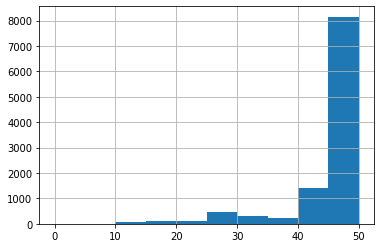

In [57]:
df['Power'].hist(range=(0, 50))

### Кодирование признаков Ordinal Encoding

In [58]:
df = df.copy()
df = df.drop(['DateCrawled','DateCreated','NumberOfPictures','PostalCode','LastSeen'], axis=1) # извлеките признаки 

In [59]:
encoder = OrdinalEncoder()
df1 = df.copy()
cat_list = ['VehicleType','Gearbox','Model','NotRepaired','FuelType','Brand']
df1.loc[:,cat_list] =encoder.fit_transform(df1.loc[:,cat_list])


<AxesSubplot:>

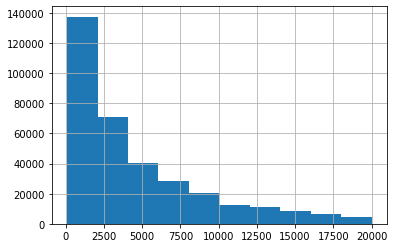

In [60]:
df1['Price'].hist()

## Обучение моделей

### Разделяю признаки

In [61]:
target = df1['Price']

features = df1.drop(['Price'], axis=1)

features_train, features_test_valid1, target_train, target_test_valid1 = train_test_split(features, target, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)
# ОБУЧАЮЩИЮ ВЫБОРКУ Делю на валидную и тестовую выборку
features_test_valid, features_valid, target_test_valid, target_valid = train_test_split(features_test_valid1, target_test_valid1, 
                                                                              test_size=0.5, 
                                                                              random_state=12345)

In [62]:
for i in [features_train, features_valid, target_train, target_valid,features_test_valid,target_test_valid]:
    print(i.shape)

(204630, 10)
(68210, 10)
(204630,)
(68210,)
(68210, 10)
(68210,)


In [63]:
df1.shape

(341050, 11)

In [64]:
df.shape

(341050, 11)

### Подготовка данных для линейной регрессии

#### Кодирование признаков OHE

In [65]:
### Кодирование признаков OHE
data=df[['Price','VehicleType','Gearbox','Model','Brand','NotRepaired','Power','RegistrationYear','Kilometer']]

data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head(5)

,Price,Power,RegistrationYear,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,98.0,1993.0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,190.0,2011.0,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,163.0,2004.0,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,75.0,2001.0,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,69.0,2008.0,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341050 entries, 0 to 354364
Columns: 304 entries, Price to NotRepaired_yes
dtypes: float64(2), int64(2), uint8(300)
memory usage: 110.6 MB


#### Разделяю признаки

In [67]:
target_ohe = data_ohe['Price']

#features = df1.drop(['Price','DateCrawled','DateCreated','NumberOfPictures'], axis=1)

features_ohe = data_ohe.drop('Price', axis=1)

features_train_ohe, features_test_valid1_ohe, target_train_ohe, target_test_valid1_ohe = train_test_split(features_ohe, target_ohe, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)
# ОБУЧАЮЩИЮ ВЫБОРКУ Делю на валидную и тестовую выборку
features_test_valid_ohe, features_valid_ohe, target_test_valid_ohe, target_valid_ohe = train_test_split(features_test_valid1_ohe, target_test_valid1_ohe, 
                                                                              test_size=0.5, 
                                                                              random_state=12345)

#### Масштабирование

Применю для того что бы значение всех признаков были в одном масштабе


In [68]:

col=['Power','RegistrationYear','Kilometer']
col

['Power', 'RegistrationYear', 'Kilometer']

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features_train[col])

features_train_ohe[col] = scaler.transform(features_train_ohe[col])
features_valid_ohe[col] = scaler.transform(features_valid_ohe[col])
features_test_valid_ohe[col] = scaler.transform(features_test_valid_ohe[col])

/tmp/ipykernel_84/2451963128.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_ohe[col] = scaler.transform(features_train_ohe[col])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_84/2451963128.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [70]:
features_train_ohe

,Power,RegistrationYear,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
172969,0.824103,0.383624,0.576271,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123616,-0.440133,-0.306182,0.576271,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119382,-0.681825,0.659546,-2.110077,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
109894,0.117618,-0.582105,0.576271,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
318665,-1.090842,-0.720066,0.576271,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165093,-0.904925,-2.099678,0.576271,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
49737,-0.533091,-0.858027,0.576271,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89782,-0.811966,-0.582105,0.576271,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
80306,0.396494,0.245663,0.576271,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Дерево решений

In [71]:
start = process_time()
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 20):
    model = DecisionTreeRegressor(random_state=12345,max_depth=depth)# инициализируйте модель DecisionTreeRegressor с параметром random_state=12345 и #max_depth=depth
    model.fit(features_train,target_train) # обучите модель на тренировочной выборке
    predictions_valid = model.predict(features_valid) # получите предсказания модели на валидационной выборке
    result =mean_squared_error(target_valid, predictions_valid)**0.5# посчитайте значение метрики rmse на валидационной выборке # посчитайте значение #метрики rmse на валидационной выборке
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth
stop = process_time()  
start1 = process_time()
predictions_valid = model.predict(features_test_valid) 
stop1 = process_time() 
result =mean_squared_error(target_test_valid, predictions_valid)**0.5

DecisionTreeRMSE=round(best_result, 2)#best_result
DecisionTreeRMSE_test=round(result, 2)#result
DecisionTree_training=round(stop-start, 5)#
DecisionTree_predict=round(stop1-start1, 5)
print("RMSE наилучшей модели на валидационной выборке:", best_result, "Глубина дерева:", best_depth,"RMSE модели на тестовой выборке",DecisionTreeRMSE_test)
print("Время обучения", DecisionTree_training,"Время предсказания",DecisionTree_predict)

RMSE наилучшей модели на валидационной выборке: 1973.8046371110236 Глубина дерева: 13 RMSE модели на тестовой выборке 2111.63
Время обучения 8.12673 Время предсказания 0.02137


### Линейная регрессия c кодированием   OHE и масштабированием

In [72]:

start = process_time()
model = LinearRegression()# инициализируйте модель LinearRegression
model.fit(features_train_ohe,target_train_ohe) # обучите модель на тренировочной выборке
stop = process_time()  
start1 = process_time()
predictions_valid = model.predict(features_test_valid_ohe) # получите предсказания модели на валидационной выборке
stop1 = process_time() 

LinearRegression_RMSE =mean_squared_error(target_test_valid_ohe, predictions_valid)**0.5# посчитайте значение метрики rmse на валидационной выборке # посчитайте значение #метрики rmse на валидационной выборке # посчитайте значение метрики RMSE на валидационной выборке#print("RMSE модели линейной регрессии на валидационной выборке:", result)
LinearRegression_RMSE=round(LinearRegression_RMSE, 2)
LinearRegression_training=round(stop-start, 5)
LinearRegression_predict=round(stop1-start1, 5)
print("RMSE=",LinearRegression_RMSE)
print("Время обучения", LinearRegression_training,"Время предсказания",LinearRegression_predict)

RMSE= 2722.06
Время обучения 23.23071 Время предсказания 0.24473


### Линейная регрессия с кодированием Ordinal Encoding

In [73]:
start = process_time()
model = LinearRegression()# инициализируйте модель LinearRegression
model.fit(features_train,target_train) # обучите модель на тренировочной выборке
stop = process_time()  
start1 = process_time()
predictions_valid = model.predict(features_test_valid) # получите предсказания модели на валидационной выборке
stop1 = process_time() 

LinearRegression_RMSE_new =mean_squared_error(target_test_valid, predictions_valid)**0.5# посчитайте значение метрики rmse на валидационной выборке # посчитайте значение #метрики rmse на валидационной выборке # посчитайте значение метрики RMSE на валидационной выборке#print("RMSE модели линейной регрессии на валидационной выборке:", result)
LinearRegression_RMSE_new=round(LinearRegression_RMSE_new, 5)
LinearRegression_training_new=round(stop-start, 5)
LinearRegression_predict_new=round(stop1-start1, 5)
print("RMSE=",LinearRegression_RMSE_new)
print("Время обучения", LinearRegression_training_new,"Время предсказания",LinearRegression_predict_new)

RMSE= 3009.60088
Время обучения 0.13121 Время предсказания 0.01877


### Случайный лес

In [74]:
start = process_time()
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model =RandomForestRegressor(random_state=12345, n_estimators=est,max_depth=depth) # инициализируйте модель RandomForestRegressor с параметрами #random_state=12345, n_estimators=est и max_depth=depth
        model.fit(features_train,target_train) # обучите модель на тренировочной выборке
        predictions_valid = model.predict(features_valid) # получите предсказания модели на валидационной выборке
        result =mean_squared_error(target_valid, predictions_valid)**0.5 # посчитайте значение метрики rmse на валидационной выборке
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
stop = process_time() 

start1 = process_time()
predictions_valid = model.predict(features_test_valid) 
stop1 = process_time() 
result =mean_squared_error(target_test_valid, predictions_valid)**0.5

ForestRegressorRMSE=round(best_result, 2)
ForestRegressorRMSE_test=round(result, 2)
ForestRegressor_training=round(stop-start, 5)
ForestRegressor_predict=round(stop1-start1, 5)
print("RMSE наилучшей модели на валидационной выборке:", best_result, "Глубина дерева:", best_depth,"RMSE модели на тестовой выборке")
print("Время обучения", DecisionTree_training,"Время предсказания",DecisionTree_predict)

print("RMSE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth,"RMSE модели на тестовой выборке" ,result)

RMSE наилучшей модели на валидационной выборке: 1924.0703276706827 Глубина дерева: 10 RMSE модели на тестовой выборке
Время обучения 8.12673 Время предсказания 0.02137
RMSE наилучшей модели на валидационной выборке: 1924.0703276706827 Количество деревьев: 50 Максимальная глубина: 10 RMSE модели на тестовой выборке 1937.8644018693822


### LightGBM 

In [75]:
start = process_time()
model_LGMB = lgb.LGBMRegressor(max_depth = 20, num_leaves = 202,  random_state = 12345)
model_LGMB.fit(features_train, target_train)
stop = process_time() 

In [76]:
start1 = process_time()
predict_LGMB = model_LGMB.predict(features_test_valid)
stop1 = process_time() 

In [77]:
rsme_LGMB = mean_squared_error(target_test_valid, predict_LGMB) ** 0.5
rsme_LGMB=round(rsme_LGMB, 2)
LGMB_training=round(stop-start, 5)
LGMB_predict=round(stop1-start1, 5)

print("RMSE градиента бустинга LightGBM=",rsme_LGMB)
print("Время обучения",LGMB_training)
print("Время предсказания",LGMB_predict)

RMSE градиента бустинга LightGBM= 1626.06
Время обучения 296.99518
Время предсказания 0.80147


### CatBoostRegressor 



In [78]:
start = process_time()
import numpy as np
from catboost import Pool, CatBoostRegressor
model = CatBoostRegressor(iterations=20, 
                          depth=16, 
                          learning_rate=1, 
                          loss_function='RMSE')

model.fit(features_train,target_train)
stop = process_time() 

start1 = process_time()
preds = model.predict(features_test_valid)
stop1 = process_time() 
CatBoostRegressor_RMSE =mean_squared_error(target_test_valid, preds)**0.5# посчитайте значение метрики rmse на валидационной выборке # посчитайте значение #метрики rmse на валидационной выборке # посчитайте значение метрики RMSE на валидационной выборке#print("RMSE модели линейной регрессии на валидационной выборке:", result)
CatBoostRegressor_RMSE=round(CatBoostRegressor_RMSE, 2)#
CatBoostRegressor_training = round(stop-start, 5)#
CatBoostRegressor_predict=round(stop1-start1, 5)#
print("RMSE градиента бустинга CatBoostRegressor=",CatBoostRegressor_RMSE)
print("Время обучения",CatBoostRegressor_training)
print("Время предсказания",CatBoostRegressor_predict)

0:	learn: 2172.7792453	total: 1.99s	remaining: 37.9s
1:	learn: 1950.2274805	total: 3.82s	remaining: 34.4s
2:	learn: 1851.6851733	total: 5.56s	remaining: 31.5s
3:	learn: 1783.5843065	total: 7.34s	remaining: 29.4s
4:	learn: 1724.9378334	total: 9.15s	remaining: 27.4s
5:	learn: 1693.2152334	total: 10.9s	remaining: 25.3s
6:	learn: 1654.4106017	total: 12.6s	remaining: 23.4s
7:	learn: 1615.0088847	total: 14.4s	remaining: 21.6s
8:	learn: 1589.3657219	total: 16.2s	remaining: 19.8s
9:	learn: 1554.9734330	total: 17.9s	remaining: 17.9s
10:	learn: 1533.5865827	total: 19.7s	remaining: 16.1s
11:	learn: 1515.2160823	total: 21.5s	remaining: 14.3s
12:	learn: 1499.7949671	total: 23.2s	remaining: 12.5s
13:	learn: 1474.0099889	total: 25s	remaining: 10.7s
14:	learn: 1459.5447428	total: 26.7s	remaining: 8.91s
15:	learn: 1448.5555611	total: 28.5s	remaining: 7.12s
16:	learn: 1417.3235925	total: 30.3s	remaining: 5.34s
17:	learn: 1400.9142944	total: 32s	remaining: 3.56s
18:	learn: 1382.8059349	total: 33.8s	remai

## Анализ моделей

In [79]:
table = pd.DataFrame({'name': ['Дерево решений', 'Линейная регресия кодирование OHE и масштабирование', 'Линейная регресия кодирование ОЕ','Случайный лес','Градиентный бустинг LGMB','Градиентный бустинг CatBoost']
                      , 'rsme': [DecisionTreeRMSE_test, LinearRegression_RMSE,LinearRegression_RMSE_new, ForestRegressorRMSE_test,rsme_LGMB,CatBoostRegressor_RMSE], 
                      'Время обучения': [DecisionTree_training, LinearRegression_training,LinearRegression_training_new, ForestRegressor_training,LGMB_training,CatBoostRegressor_training]
                     ,'Время предсказания':[DecisionTree_predict,LinearRegression_predict,LinearRegression_predict_new,ForestRegressor_predict,LGMB_predict,CatBoostRegressor_predict]})

In [80]:
table

,name,rsme,Время обучения,Время предсказания
0,Дерево решений,2111.63000,8.12673,0.02137
1,Линейная регресия кодирование OHE и масштабиро...,2722.06000,23.23071,0.24473
2,Линейная регресия кодирование ОЕ,3009.60088,0.13121,0.01877
3,Случайный лес,1937.86000,263.05287,0.27346
4,Градиентный бустинг LGMB,1626.06000,296.99518,0.80147
5,Градиентный бустинг CatBoost,1794.78000,35.70367,0.02221


Как видно у Линейной регресии самое большое rsme, удалим ее из анализа

График RMSE

<AxesSubplot:xlabel='name'>

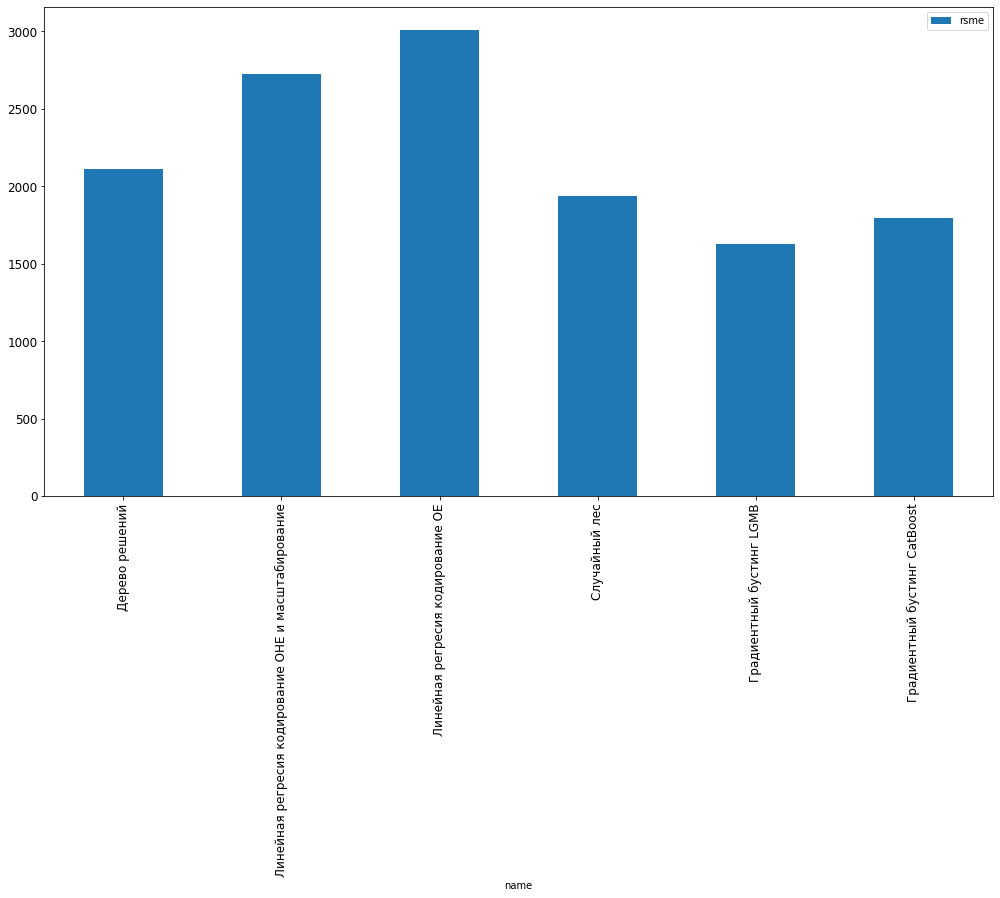

In [81]:
table.plot(x='name',y='rsme',kind='bar',figsize=(17,9),fontsize=12)

График Время обучения

<AxesSubplot:xlabel='name'>

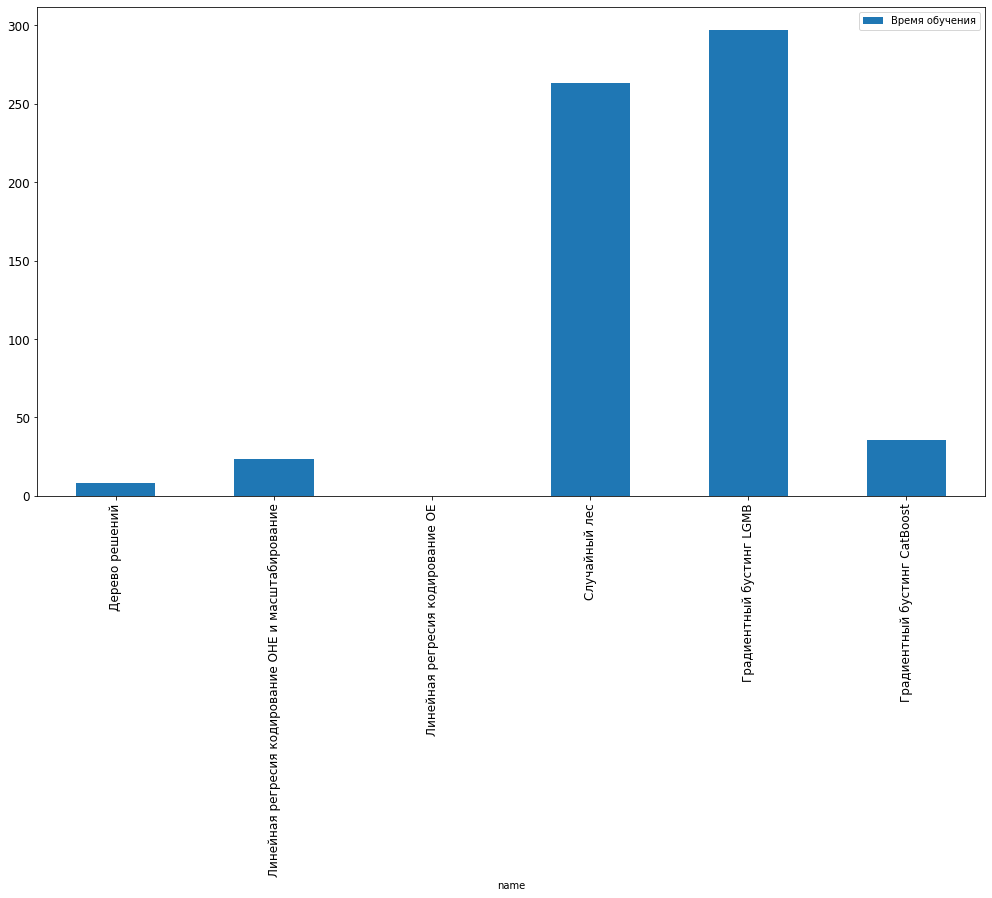

In [82]:
table.plot(x='name',y='Время обучения',kind='bar',figsize=(17,9),fontsize=12)


<AxesSubplot:xlabel='name'>

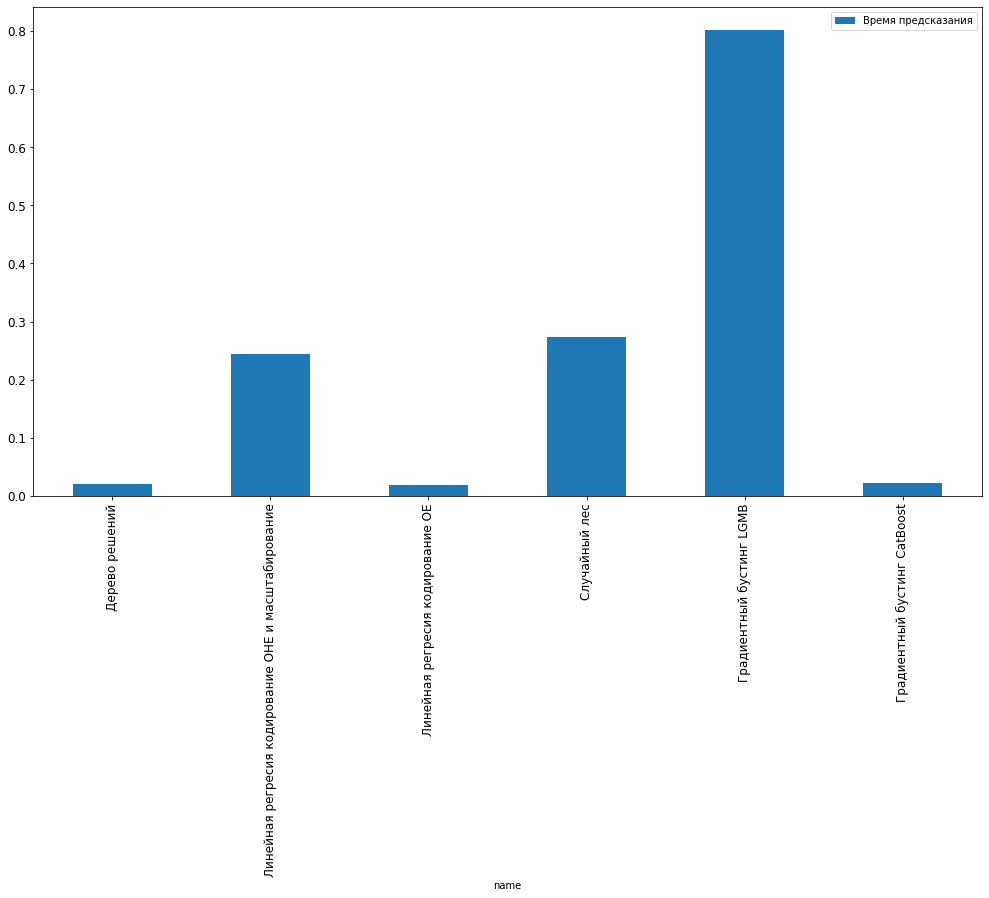

In [83]:
table.plot(x='name',y='Время предсказания',kind='bar',figsize=(17,9),fontsize=12)

## Заключение 
Самое лучше RMSE у модели градинтного бустинга  LightGBM, но у CatBoostRegressor время обучения и предсказания на порядок лучше, при этом значение RMSE больше около 10%. 
По этому рекомендую модель градиентного бустинга CatBoostRegressor